### Initalizing spark

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.linalg import DenseVector
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.types as typ
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


import re
import pandas as pd

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Jonas_rentalPrice-Copy1") \
    .config("spark.executor.memory", '4g') \
    .config('spark.executor.cores', '1') \
    .config('spark.cores.max', '1') \
    .config("spark.driver.memory",'1g') \
    .getOrCreate()

sc = spark.sparkContext
sqlCtx = SQLContext(sc)

Downloading the data as a pandas data frame.

In [2]:
train_data_pd = pd.read_json("data/train.json")

Taking a look at the data.

In [3]:
train_data_pd

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,low
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,high
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,low
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street,low
100014,2.0,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],40.7429,6894514,-74.0028,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6894514_9abb8592...,7995,350 West 18th Street,medium
100016,1.0,2,3ba49a93260ca5df92fde024cb4ca61f,2016-04-27 03:19:56,Stunning unit with a great location and lots o...,West 107th Street,"[prewar, elevator, Dogs Allowed, Cats Allowed,...",40.8012,6930771,-73.9660,01287194f20de51872e81f660def4784,[https://photos.renthop.com/2/6930771_7e3622b6...,3600,210 West 107th Street,low
100020,2.0,1,0372927bcb6a0949613ef5bf893bbac7,2016-04-13 06:01:42,"This huge sunny ,plenty of lights 1 bed/2 bath...",West 21st Street,"[Doorman, Elevator, Pre-War, Terrace, Laundry ...",40.7427,6867392,-73.9957,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/6867392_b18283f6...,5645,155 West 21st Street,low
100026,1.0,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",40.8234,6898799,-73.9457,c1a6598437b7db560cde66e5a297a53f,[https://photos.renthop.com/2/6898799_3759be4c...,1725,63 Hamilton Terrace,medium
100027,2.0,4,0,2016-04-02 02:58:15,This is a spacious four bedroom with every bed...,522 E 11th,"[Dishwasher, Hardwood Floors]",40.7278,6814332,-73.9808,23a01ea7717b38875f5b070282d1b9d2,[https://photos.renthop.com/2/6814332_e19a8552...,5800,522 E 11th,low


Create a pySpark DataFrame of the pandas Data Frame.

In [4]:
train_data_df = sqlCtx.createDataFrame(train_data_pd)
train_data_df.cache()

DataFrame[bathrooms: double, bedrooms: bigint, building_id: string, created: string, description: string, display_address: string, features: array<string>, latitude: double, listing_id: bigint, longitude: double, manager_id: string, photos: array<string>, price: bigint, street_address: string, interest_level: string]

Printing the schema. Seems to be ok for most part. The `created` should be changed from string to time object.

In [5]:
train_data_df.printSchema()

root
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- building_id: string (nullable = true)
 |-- created: string (nullable = true)
 |-- description: string (nullable = true)
 |-- display_address: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- latitude: double (nullable = true)
 |-- listing_id: long (nullable = true)
 |-- longitude: double (nullable = true)
 |-- manager_id: string (nullable = true)
 |-- photos: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- price: long (nullable = true)
 |-- street_address: string (nullable = true)
 |-- interest_level: string (nullable = true)



Show the first row in the pySpark Data Frame.

In [6]:
train_data_df.show(1)

+---------+--------+--------------------+-------------------+--------------------+-------------------+--------+--------+----------+---------+--------------------+--------------------+-----+--------------------+--------------+
|bathrooms|bedrooms|         building_id|            created|         description|    display_address|features|latitude|listing_id|longitude|          manager_id|              photos|price|      street_address|interest_level|
+---------+--------+--------------------+-------------------+--------------------+-------------------+--------+--------+----------+---------+--------------------+--------------------+-----+--------------------+--------------+
|      1.5|       3|53a5b119ba8f7b61d...|2016-06-24 07:54:24|A Brand New 3 Bed...|Metropolitan Avenue|      []| 40.7145|   7211212| -73.9425|5ba989232d0489da1...|[https://photos.r...| 3000|792 Metropolitan ...|        medium|
+---------+--------+--------------------+-------------------+--------------------+--------------

Printing the `bathrooms` column and sorting on the most frequent number of bathrooms.

In [7]:
train_data_df.groupBy('bathrooms').count().sort('count', ascending=False).show()

+---------+-----+
|bathrooms|count|
+---------+-----+
|      1.0|39422|
|      2.0| 7660|
|      3.0|  745|
|      1.5|  645|
|      0.0|  313|
|      2.5|  277|
|      4.0|  159|
|      3.5|   70|
|      4.5|   29|
|      5.0|   20|
|      5.5|    5|
|      6.0|    4|
|      7.0|    1|
|      6.5|    1|
|     10.0|    1|
+---------+-----+



Checking out the apartment with 10 bathrooms.

In [8]:
train_data_df.filter(train_data_df["bathrooms"] == 10.0).show()

+---------+--------+--------------------+-------------------+--------------------+---------------+--------------------+--------+----------+---------+--------------------+--------------------+-----+--------------+--------------+
|bathrooms|bedrooms|         building_id|            created|         description|display_address|            features|latitude|listing_id|longitude|          manager_id|              photos|price|street_address|interest_level|
+---------+--------+--------------------+-------------------+--------------------+---------------+--------------------+--------+----------+---------+--------------------+--------------------+-----+--------------+--------------+
|     10.0|       2|424f8014bddc288d2...|2016-04-09 04:34:31|***The building?s...|       W 52 St.|[Doorman, Elevato...| 40.7633|   6849204| -73.9849|0c71a59cb70215fbf...|[https://photos.r...| 3600|  260 W 52 St.|           low|
+---------+--------+--------------------+-------------------+--------------------+------

We we that it is a room with 2 bedrooms. Highly likely that it is a typo. We continue to check out the rental with 7 and 6.5 bathrooms.

In [9]:
train_data_df.filter((train_data_df["bathrooms"] == 7.0) | (train_data_df["bathrooms"] == 6.5) ).show()

+---------+--------+--------------------+-------------------+--------------------+--------------------+--------------------+--------+----------+---------+--------------------+--------------------+-----+--------------------+--------------+
|bathrooms|bedrooms|         building_id|            created|         description|     display_address|            features|latitude|listing_id|longitude|          manager_id|              photos|price|      street_address|interest_level|
+---------+--------+--------------------+-------------------+--------------------+--------------------+--------------------+--------+----------+---------+--------------------+--------------------+-----+--------------------+--------------+
|      6.5|       7|3be1175591e290053...|2016-06-22 03:15:54|This landmark Eng...|206 Upper Mountai...|[Garage, Garden, ...| 40.8336|   7198431|  -74.216|1d019cccf631394cd...|[https://photos.r...|14500|206 Upper Mountai...|           low|
|      7.0|       5|                   0|201

We see that these are way more expensive than the rental with 10 bathrooms which further the suspision that it is a typo. 

Printing the `bedrooms` column and sorting on the most frequent number of bedrooms.

In [10]:
train_data_df.groupBy('bedrooms').count().sort('count', ascending=False).show()

+--------+-----+
|bedrooms|count|
+--------+-----+
|       1|15752|
|       2|14623|
|       0| 9475|
|       3| 7276|
|       4| 1929|
|       5|  247|
|       6|   46|
|       7|    2|
|       8|    2|
+--------+-----+



Check out the 8 room apartments.

In [11]:
train_data_df.filter((train_data_df["bedrooms"] == 8)).show()

+---------+--------+--------------------+-------------------+--------------------+----------------+--------------------+--------+----------+---------+--------------------+--------------------+-----+----------------+--------------+
|bathrooms|bedrooms|         building_id|            created|         description| display_address|            features|latitude|listing_id|longitude|          manager_id|              photos|price|  street_address|interest_level|
+---------+--------+--------------------+-------------------+--------------------+----------------+--------------------+--------+----------+---------+--------------------+--------------------+-----+----------------+--------------+
|      4.0|       8|2d51ec2a54cf05468...|2016-06-25 06:09:20|Gorgeous 8 bedroo...|      Greene Ave|[Hardwood Floors,...| 40.6881|   7217045| -73.9553|9ba3641676cc717a8...|                  []| 6500|  393 Greene Ave|           low|
|      3.0|       8|f8bff653aae7c7555...|2016-06-13 02:47:37|Please note tha

We check for the `building_id` and conclude that we have 8286 missing values here.

In [12]:
train_data_df.groupBy('building_id').count().sort('count', ascending=False).show(5)

+--------------------+-----+
|         building_id|count|
+--------------------+-----+
|                   0| 8286|
|96274288c84ddd7d5...|  275|
|11e1dec9d14b1a9e5...|  215|
|80a120d6bc3aba97f...|  213|
|bb8658a3e432fb62a...|  212|
+--------------------+-----+
only showing top 5 rows



Displaying the `created` column.

In [13]:
train_data_df[["created"]].show(5)

+-------------------+
|            created|
+-------------------+
|2016-06-24 07:54:24|
|2016-06-12 12:19:27|
|2016-04-17 03:26:41|
|2016-04-18 02:22:02|
|2016-04-28 01:32:41|
+-------------------+
only showing top 5 rows



Changing the `created` column to timestamp objects instead of strings.

In [14]:
train_data_df = train_data_df.withColumn("created", F.to_timestamp("created"))
train_data_df.cache()

DataFrame[bathrooms: double, bedrooms: bigint, building_id: string, created: timestamp, description: string, display_address: string, features: array<string>, latitude: double, listing_id: bigint, longitude: double, manager_id: string, photos: array<string>, price: bigint, street_address: string, interest_level: string]

We create a coulm called `Day_of_week` which contains the day of the week the rental was created.

In [15]:
day_of_week = train_data_df.withColumn("Day_of_week", F.dayofweek(train_data_df["created"]))
day_of_week = day_of_week[["Day_of_week"]]
day_of_week.show(5)

+-----------+
|Day_of_week|
+-----------+
|          6|
|          1|
|          1|
|          2|
|          5|
+-----------+
only showing top 5 rows



We want to plot the count of the different days that the rental was created.

In [16]:
day_of_week_pd = day_of_week.toPandas()

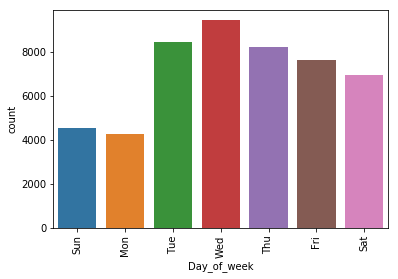

In [17]:
ax = sns.countplot(x="Day_of_week", data = day_of_week_pd)
ax.set_xticklabels(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"], rotation='vertical', fontsize=10)
plt.show()

We create a data frame with `longitude` and `latitude` in order to plot the positioning of the rental unit on a map.

In [18]:
long_lat_df = train_data_df[["longitude", "latitude"]]
long_lat_df.cache()

DataFrame[longitude: double, latitude: double]

In [19]:
long_lat_df.show(5)

+---------+--------+
|longitude|latitude|
+---------+--------+
| -73.9425| 40.7145|
| -73.9667| 40.7947|
| -74.0018| 40.7388|
| -73.9677| 40.7539|
| -73.9493| 40.8241|
+---------+--------+
only showing top 5 rows



Printing a statistic summary, mostly to see if there were any strange values. Which there were since we dont think that there are any rental units with longitude and latitude = 0.0

In [20]:
long_lat_df.describe().show()

+-------+------------------+------------------+
|summary|         longitude|          latitude|
+-------+------------------+------------------+
|  count|             49352|             49352|
|   mean|-73.95571552115474| 40.74154482290508|
| stddev|1.1779119215716662|0.6385353439544775|
|    min|          -118.271|               0.0|
|    max|               0.0|           44.8835|
+-------+------------------+------------------+



We see how many rental units that have longitude and latitude = 0.0

In [21]:
print("Number of observations with missing longitude: {}" .format(long_lat_df.filter(long_lat_df["longitude"] == 0.0).count()))
print("Number of observations with missing latitude: {}" .format(long_lat_df.filter(long_lat_df["latitude"] == 0.0).count()))

Number of observations with missing longitude: 12
Number of observations with missing latitude: 12


Could these be the same observations?

In [22]:
print("Number of observations with missing longitude and latitude: {}".format(long_lat_df.filter((long_lat_df["latitude"] == 0.0) & (long_lat_df["longitude"] == 0.0)).count()))

Number of observations with missing longitude and latitude: 12


Yes they are... So how many are remaining?

In [23]:
long_lat_df.filter(long_lat_df["latitude"] != 0.0).count()

49340

To plot the apartments we use the package `folium` which can make interactive plots and we can get more information of the rental units in the plot.

Inspiration from blogpost: https://nbviewer.jupyter.org/github/vincentropy/python_cartography_tutorial/blob/master/part1_basic_folium_maps.ipynb

In [24]:
!pip install --upgrade folium
import folium

Requirement already up-to-date: folium in /opt/conda/lib/python3.6/site-packages (0.7.0)


We create a function that places each of the units on the map. The color of the apartment corresponds to the factor `interest_level` which has not been investigated thoroughly yet. The size of the circle is based on the price which can be displayed by *klicking* the circle, along with the `street_address`.

In [25]:
def plot_rental_locatinos(rental_locatinos):
        # generate a new map
    folium_map = folium.Map(location=[40.738, -73.98],
                            zoom_start=13,
                            tiles="CartoDB dark_matter",
                            width='50%')

            
    for index, row in rental_locatinos.iterrows():
        
            popup_text = "{}<br> Price: {}<br>"
            popup_text = popup_text.format(row["street_address"], row["price"])
            
            if row["interest_level"] == 'high':
                color="#00FF00" # green
            if row["interest_level"] == 'medium':
                color="#FFFF00" # yellow 
            if row["interest_level"] == 'low':
                color="#FF6347" # red
                
            radius = row["price"]/1000
        
            folium.CircleMarker(location=(row["latitude"],
                                      row["longitude"]),
                            radius=radius,
                            color=color,
                            popup=popup_text,
                            fill=True).add_to(folium_map)
    return folium_map

Since our data set is too big for all rental units to be displayed a subsample of 1000 units are changed into a pandas data frame which is then plotted using the above constructed function `plot_rental_locatinos`.

In [26]:
sample_pd = train_data_pd.sample(n = 1000)

The user constructed function `plot_rental_locatinos`

In [27]:
plot_rental_locatinos(sample_pd)

421 Hudson Street
Price: 4490000

### Handeling of the column `features`

We want to explode and split on the column `features`. So that each feature gets it's own column with binary values.

In [28]:
list = train_data_df[["features"]].collect()[1][0]
list

['Doorman', 'Elevator', 'Fitness Center', 'Cats Allowed', 'Dogs Allowed']

We have to handele the rentals with missing featurses by adding `missing feature` as a feature. Here are the 2 first listings with missing features.

In [29]:
train_data_df.filter(F.size("features")==0)[["listing_id", "features"]].show(2)

+----------+--------+
|listing_id|features|
+----------+--------+
|   7211212|      []|
|   6894514|      []|
+----------+--------+
only showing top 2 rows



But first since the column `features` is a list containing strings, we want to mearge the list of strings to one string. We do this by constructing a `UserDefinedFunction` named `string_assembler` which uses the `','.join()` to join strings in a list and separating them with a **,** . This is what we do: \['dog', 'cat'\] -> 'dog,cat'.

In [30]:
string_assembler = F.UserDefinedFunction(lambda x: ','.join(x), typ.StringType())

The function `string_assembler` is used on the column `features`.

In [31]:
feat_df = train_data_df.withColumn("features", string_assembler(train_data_df["features"]))
feat_df.cache()

DataFrame[bathrooms: double, bedrooms: bigint, building_id: string, created: timestamp, description: string, display_address: string, features: string, latitude: double, listing_id: bigint, longitude: double, manager_id: string, photos: array<string>, price: bigint, street_address: string, interest_level: string]

All strings are set to lower case.

In [32]:
feat_df = feat_df.withColumn("features", F.lower(feat_df["features"]))

A display of what we have done. Note that the first row is missing any `features`. This is valuable information as well since a listing ad without information about the rental place could determin the popularity of the place.

In [33]:
feat_df[["features"]].show(5)

+--------------------+
|            features|
+--------------------+
|                    |
|doorman,elevator,...|
|laundry in buildi...|
|hardwood floors,n...|
|             pre-war|
+--------------------+
only showing top 5 rows



We impute all missing `features` with the string "missing feature".

In [34]:
feat_df = feat_df.withColumn("features", 
                             F.when(feat_df["features"] == '', 'missing features')
                             .otherwise(feat_df["features"]))

The results are shown.

In [35]:
feat_df[["features"]].show(5)

+--------------------+
|            features|
+--------------------+
|    missing features|
|doorman,elevator,...|
|laundry in buildi...|
|hardwood floors,n...|
|             pre-war|
+--------------------+
only showing top 5 rows



We want to split the `features` sting on **,** and on * since some listings had all features in one long string with * separating the different features. 

In [36]:
feat_df = feat_df.withColumn("features_list", F.split(feat_df["features"], ',| \* '))

The results are shown.

In [37]:
feat_df[["features_list"]].show(5)

+--------------------+
|       features_list|
+--------------------+
|  [missing features]|
|[doorman, elevato...|
|[laundry in build...|
|[hardwood floors,...|
|           [pre-war]|
+--------------------+
only showing top 5 rows



Now we want to create one feature be uniqe feature in the `features`. The first step is to 'explode' the features so that each single feature gets it's own row. (To see the tables go into edit mode(press Enter))

+----------+---------------+       +----------+---------------+
|listing_id|   col_list    |       |listing_id|  ex_col_list  |
+----------+---------------+    -> +----------+---------------+ 
|  12345   |"item1","item2"|       |  12345   |   "item1"     |
+----------+---------------+       |  12345   |   "item2"     |
                                   +----------+---------------+ 


In [38]:
feat_df_ex = feat_df.withColumn("ex_features_list", F.explode(feat_df["features_list"]))
feat_df_ex.cache()

DataFrame[bathrooms: double, bedrooms: bigint, building_id: string, created: timestamp, description: string, display_address: string, features: string, latitude: double, listing_id: bigint, longitude: double, manager_id: string, photos: array<string>, price: bigint, street_address: string, interest_level: string, features_list: array<string>, ex_features_list: string]

Displaying the exploded list.

In [39]:
feat_df_ex[["listing_id", "ex_features_list"]].show(5)

+----------+----------------+
|listing_id|ex_features_list|
+----------+----------------+
|   7211212|missing features|
|   7150865|         doorman|
|   7150865|        elevator|
|   7150865|  fitness center|
|   7150865|    cats allowed|
+----------+----------------+
only showing top 5 rows



We look for the most common features listed in `features`.

In [40]:
feat_df_ex.groupBy("ex_features_list").count().sort('count', ascending=False).show()

+-------------------+-----+
|   ex_features_list|count|
+-------------------+-----+
|           elevator|26273|
|    hardwood floors|23558|
|       cats allowed|23540|
|       dogs allowed|22035|
|            doorman|20970|
|         dishwasher|20820|
|laundry in building|18944|
|             no fee|18081|
|     fitness center|13257|
|    laundry in unit| 9435|
|            pre-war| 9149|
|          roof deck| 6557|
|      outdoor space| 5270|
|        dining room| 5151|
|high speed internet| 4299|
|   missing features| 3218|
|            balcony| 3058|
|      swimming pool| 2730|
|   new construction| 2608|
|            terrace| 2313|
+-------------------+-----+
only showing top 20 rows



Doing some more cleaning of the features, rmoving things like . * ! removing double spaces and trimming spaces at the start and end of string.

In [41]:
feat_df_ex = feat_df_ex.withColumn("ex_features_list", 
                                   F.regexp_replace(feat_df_ex["ex_features_list"], "\* ", ""))

feat_df_ex = feat_df_ex.withColumn("ex_features_list", 
                                   F.regexp_replace(feat_df_ex["ex_features_list"], "\*", ""))

feat_df_ex = feat_df_ex.withColumn("ex_features_list", 
                                   F.regexp_replace(feat_df_ex["ex_features_list"], "\*\*", ""))

feat_df_ex = feat_df_ex.withColumn("ex_features_list", 
                                   F.regexp_replace(feat_df_ex["ex_features_list"], "\!", ""))

feat_df_ex = feat_df_ex.withColumn("ex_features_list", 
                                   F.regexp_replace(feat_df_ex["ex_features_list"], "\.", ""))

feat_df_ex = feat_df_ex.withColumn("ex_features_list", 
                                   F.regexp_replace(feat_df_ex["ex_features_list"], "  ", " "))

feat_df_ex = feat_df_ex.withColumn("ex_features_list", 
                                   F.trim(feat_df_ex["ex_features_list"]))

Creating a dummy row containing only 1's for the `pivot` function we are about to use.

In [42]:
feat_df_ex = feat_df_ex.withColumn("constant_val", F.lit(1))

Grouping by `listing_id`, `pivot`ing so each feature in `ex_features_list` becomes it's own column containing either a 1 or 0. The `agg` fucntion is used since the `pivot` function creates a `pivot` object. Then `coalesce` is used to return a new DataFrame that has exactly `F.first("constant_val")` partitions. `F.first("constant_val")` is just to get the number of partitions `coalesce` needs.

In [43]:
feat_df_piv = feat_df_ex\
                   .groupBy("listing_id")\
                   .pivot("ex_features_list")\
                   .agg(F.coalesce(F.first("constant_val")))
feat_df_piv.cache()

DataFrame[listing_id: bigint, $1000 move-in visa giftcard will be handed to new tenants upon rental lease signing: int, $1500 move-in visa giftcard will be handed to new tenants upon rental lease signing: int, $250 application fee with background and credit check board interview and approval: int, $250 security deposit: int, $500 security deposit: int, $600 gift card for move-ins prior to june 19: int, & atm machine on-site: int, -greal location: int, 000 sf fitness center: int, 000 sq ft landscaped terrace complete with an organic garden: int, 000 square foot exclusive courtyard oasis for via residents: int, 000-square foot sun deck• free wifi in marc club: int, 1 blk to bedford l: int, 1 blk to bedford l stop: int, 1 blk to l train: int, 1 blk to the park: int, 1 blk to train: int, 1 br or conv 2: int, 1 mo broker's fee 18 mo lease: int, 1 month free: int, 1 month free rent: int, 1/2 bath: int, 1/2 blk to bedford l: int, 1/2 month fee: int, 1100 sq ft: int, 1200sq ft: int, 12th st & 

All newly created columns are displayed.

In [44]:
feat_df_piv.columns

['listing_id',
 '$1000 move-in visa giftcard will be handed to new tenants upon rental lease signing',
 '$1500 move-in visa giftcard will be handed to new tenants upon rental lease signing',
 '$250 application fee with background and credit check board interview and approval',
 '$250 security deposit',
 '$500 security deposit',
 '$600 gift card for move-ins prior to june 19',
 '& atm machine on-site',
 '-greal location',
 '000 sf fitness center',
 '000 sq ft landscaped terrace complete with an organic garden',
 '000 square foot exclusive courtyard oasis for via residents',
 '000-square foot sun deck• free wifi in marc club',
 '1 blk to bedford l',
 '1 blk to bedford l stop',
 '1 blk to l train',
 '1 blk to the park',
 '1 blk to train',
 '1 br or conv 2',
 "1 mo broker's fee 18 mo lease",
 '1 month free',
 '1 month free rent',
 '1/2 bath',
 '1/2 blk to bedford l',
 '1/2 month fee',
 '1100 sq ft',
 '1200sq ft',
 '12th st & 3rd ave',
 '15 bath',
 '15 bathrooms',
 '15 baths',
 '15 marble b

The number of unique features are diplayed.

In [45]:
len(feat_df_piv.columns)

1412

We take a look at the `listing_id`s that has `elevator` listed as a feature.

In [46]:
feat_df_piv.filter(feat_df_piv["elevator"] == 1)[["listing_id", "elevator"]].show(5)

+----------+--------+
|listing_id|elevator|
+----------+--------+
|   7254129|       1|
|   6893897|       1|
|   6945698|       1|
|   6870136|       1|
|   6819131|       1|
+----------+--------+
only showing top 5 rows



The number of rental that has `elevator` listed as a feature are counted.

In [47]:
feat_df_piv.filter(feat_df_piv["elevator"] == 1).count()

26272

We take a look at the `listing_id`s that has `a/c` listed as a feature.

In [48]:
feat_df_piv.filter(feat_df_piv["a/c"] == 1)[["listing_id", "a/c"]].show(5)

+----------+---+
|listing_id|a/c|
+----------+---+
|   6817133|  1|
|   7026463|  1|
+----------+---+



Since the new data frame `feat_df_piv` now only contains the features we want to mearge this new data frame to our orignial data frame.

In [49]:
train_data_df = train_data_df.join(feat_df_piv, on = "listing_id", how = "left")
train_data_df.cache()

DataFrame[listing_id: bigint, bathrooms: double, bedrooms: bigint, building_id: string, created: timestamp, description: string, display_address: string, features: array<string>, latitude: double, longitude: double, manager_id: string, photos: array<string>, price: bigint, street_address: string, interest_level: string, $1000 move-in visa giftcard will be handed to new tenants upon rental lease signing: int, $1500 move-in visa giftcard will be handed to new tenants upon rental lease signing: int, $250 application fee with background and credit check board interview and approval: int, $250 security deposit: int, $500 security deposit: int, $600 gift card for move-ins prior to june 19: int, & atm machine on-site: int, -greal location: int, 000 sf fitness center: int, 000 sq ft landscaped terrace complete with an organic garden: int, 000 square foot exclusive courtyard oasis for via residents: int, 000-square foot sun deck• free wifi in marc club: int, 1 blk to bedford l: int, 1 blk to be

We want to store all feature columns in a list. We remove `listing_id` since it's not a feature.

In [50]:
features_col = feat_df_piv.columns
features_col.remove("listing_id")

In [51]:
type(features_col)

list

We can see that if the listing is missing the feature it displays null. We want it to display 0 instead.

In [52]:
train_data_df[["elevator"]].show(5)

+--------+
|elevator|
+--------+
|       1|
|       1|
|    null|
|       1|
|       1|
+--------+
only showing top 5 rows



We replace all new columns with 0's.

In [53]:
train_data_df = train_data_df.fillna(0, subset = features_col)

Ah it worked!

In [54]:
train_data_df[["elevator"]].show(5)

+--------+
|elevator|
+--------+
|       1|
|       1|
|       0|
|       1|
|       1|
+--------+
only showing top 5 rows



### Logistic regression
Now i try to fit a logistic regression only for all feature columns.

In [55]:
train_data_df[["elevator", "a/c"]].printSchema()

root
 |-- elevator: integer (nullable = true)
 |-- a/c: integer (nullable = true)



We need to include the lables with the model. Creates a list `cols_to_drop` to remove the columns in the original data frame. Since we need the lables in `interest_level` we don't remove those.

In [56]:
cols_to_drop = train_data_pd.columns.values.tolist()
cols_to_drop.remove("interest_level")

We create a data frame `features_df` containing only the extracted features we want to use in the model.

In [57]:
features_df = train_data_df.drop(*cols_to_drop)

The data frame is changed to a rdd to create a column with the lables and a column of dense vectors with the features.

In [58]:
imput_data = features_df.rdd.map(lambda x: (x[0], DenseVector(x[1:])))
df_dense = sqlCtx.createDataFrame(imput_data, ['label','features'])
df_dense.show(3)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  low|[0.0,0.0,0.0,0.0,...|
|  low|[0.0,0.0,0.0,0.0,...|
|  low|[0.0,0.0,0.0,0.0,...|
+-----+--------------------+
only showing top 3 rows



The lables are changed from _low, medium, high_ to 0,1,2 to be able to use logistic regression.

In [59]:
df_dense = df_dense.withColumn("label", F.when(df_dense["label"] == 'low', 0)
                                         .when(df_dense["label"] == 'medium', 1)
                                         .otherwise(2))
df_dense.cache()

We count the number of observations and see that the data set is unequal in terms of `interest_level`.

In [60]:
df_dense.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|11229|
|    2| 3839|
|    0|34284|
+-----+-----+



We split the data set into a train set (80%) and a test set (20%).

In [62]:
(train, test) = df_dense.randomSplit(seed = 1337, weights = [0.8, 0.2])

A multinomial logistic regression model is created since we have 3 lables.

In [63]:
mlr = LogisticRegression(maxIter=20, family="multinomial")

We train the model on the training set.

In [64]:
mlrModel = mlr.fit(train)

training_results = mlrModel.transform(train)
training_results.cache()
training_results.show(3)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[0.0,0.0,0.0,0.0,...|[1.54479862010256...|[0.81530847329502...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|[1.54479862010256...|[0.81530847329502...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|[1.54479862010256...|[0.81530847329502...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 3 rows



The labels and predictions are casted to a pandas data frame `confusion_matrix_pd`.

In [99]:
train_confusion_matrix_pd = training_results.select("label", "prediction").toPandas()

The training accuracy is calculated.

In [100]:
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(training_results)

The training error is calculated

In [110]:
train_error = 1.0 - accuracy
print(train_error)

0.2926120572034969


We also want to see the **training error**.

In [111]:
test_results = mlrModel.transform(test)
test_results.cache()
test_results.show(3)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[0.0,0.0,0.0,0.0,...|[1.54479862010256...|[0.81530847329502...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|[0.91246101907961...|[0.64951311716616...|       0.0|
|    0|[0.0,0.0,0.0,0.0,...|[0.91246101907961...|[0.64951311716616...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 3 rows



We calculate the test error in the same way as above.

In [112]:
test_confusion_matrix_pd = test_results.select("label", "prediction").toPandas()
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(test_results)
test_error = 1.0 - accuracy
print(test_error)

0.30939226519337015


We now want to plot the confustion matrix for the **test data**.

In [113]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_confusion_matrix_pd["label"], test_confusion_matrix_pd["prediction"])

We want to plot a nice looking confusion matrix. This is done by the function `plot_confusion_matrix` implemented bellow. The function is taken from https://scikit-learn.org and the link to the function is here: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 

In [97]:
import numpy as np
import itertools

In [94]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


The our different classnames are stored as `class_names`.

In [114]:
class_names = ["low", "medium", "high"]

The confusion matrix is plotted. We can conclude that due to the unbalanced lables most rentals are classified as _low_ and we still get about 0.3 test error.

Confusion matrix, without normalization
[[6604  138   13]
 [2113  129   18]
 [ 683   59   17]]


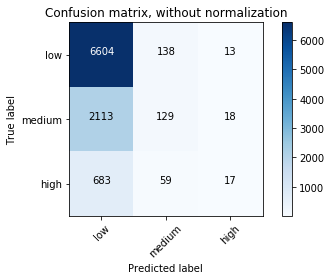

In [115]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False,
                      title='Confusion matrix, without normalization')